In [20]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn

import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

import time
import os
import glob
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark == True
plt.ion()

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
# Define data transformations for training and validation

data_transforms = {
  'train': transforms.Compose([
    # Randomly crop the image and then resize image for training data augmentation
    transforms.RandomResizedCrop(size = 224, scale=(0.08, 1.0), ratio=(0.75, 1.3333333333333333)),
    # Horizontally flip the given image randomly with a given probability here 50%.
    transforms.RandomHorizontalFlip(p = 0.5),
    # Convert image data to PyTorch tensor format
    transforms.ToTensor(),
    # Normalize the pixel values of each image channel
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
  'val': transforms.Compose([
    # Resize the image to a fixed size for validation
    transforms.Resize(256),
    # Crop the center region of the resized image for validation
    transforms.CenterCrop(224),
    # Convert image data to PyTorch tensor format
    transforms.ToTensor(),
    # Normalize the pixel values of each image channel (same as training)
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ]),
}

# Define the data directory path
data_dir = '/kaggle/input/chicken-duck-data/Image Dataset'

# Create image datasets for training and validation using ImageFolder
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                            data_transforms[x])
                  for x in ['train', 'val']}

# Create data loaders for training and validation
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                               shuffle=True, num_workers=4)
              for x in ['train', 'val']}

# Get the size of each dataset (number of images)
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

# Extract class names from the training dataset
class_names = image_datasets['train'].classes

# Set device to use GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


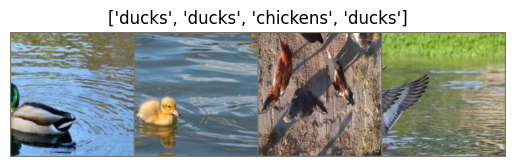

In [5]:
# Function to display an image
def show_image(input, title=None):

  # Convert PyTorch tensor to NumPy array and transpose color channels
  input = input.numpy().transpose((1, 2, 0))

  # Define mean and standard deviation values used for normalization (assuming these were used during preprocessing)
  mean = np.array([0.485, 0.456, 0.406])
  std_dev = np.array([0.229, 0.224, 0.225])

  # Denormalize the image data (reverse normalization)
  modi_input = std_dev * input + mean

  # Clip pixel values to be between 0 and 1 (valid image data range)
  modi_input = np.clip(modi_input, 0, 1)

  # Display the image using Matplotlib
  plt.imshow(modi_input)

  # Set title if provided
  if title is not None:
    plt.title(title)

  # Turn off axis labels for cleaner visualization
  plt.axis("off")

  # Add a small pause to ensure plot updates
  plt.pause(0.001)

# Get a batch of training data (images and labels)
inputs, classes = next(iter(dataloaders["train"]))

# Create a grid image from the batch using torchvision.utils.make_grid
out = torchvision.utils.make_grid(inputs)

# Generate a list of class names for the images in the batch
class_names_list = [class_names[x] for x in classes]

# Display the grid image with corresponding class names as title
show_image(out, title=class_names_list)


### Training the model

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs = 25):
  start_time = time.time()

  ## Create temporary directory to save training checkpoints
  with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")

    torch.save(model.state_dict(), best_model_params_path)

    best_acc = 0.0
    for epoch in range(num_epochs):
      print("Epoch {}/{}".format(epoch, num_epochs-1))
      print("-"*10)

      ## For each epoch there is a training and validation phase
      for phase in ["train", "val"]:
        if phase == "train":
          model.train()
        else:
          model.eval()

        running_loss = 0.0
        running_corrects = 0

        ## Iterate over data
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          ## set the parameter gradients to zero
          optimizer.zero_grad()

          ## forward pass
          with torch.set_grad_enabled(phase == "train"):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            ## backward and optimize when in training phase
            if phase == "train":
              loss.backward()
              optimizer.step()

          ## statistics
          running_loss += loss.item()*inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        if phase == "train":
          scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print("{} Loss: {:.4f} Accuracy: {:.4f}".format(phase, epoch_loss, epoch_acc))

        ## deep copy the model
        if phase == "val" and epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(model.state_dict(), best_model_params_path)

      print()

    time_elapsed = time.time() - start_time
    print("Training completed in {:.0f}m {:.0f}s".format(time_elapsed//60, time_elapsed%60))
    print("Best Validation Accuracy: {:.4f}".format(best_acc))

    ## load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

  return model

### Visualizing the predictions

In [7]:
def visualize(model, num_images=8):
  """
  Visualize predictions of the model on a specified number of validation images.

  Args:
      model: The PyTorch model to use for prediction.
      num_images (int, optional): The number of validation images to visualize. Defaults to 8.
  """

  # Save the current training mode of the model
  was_training = model.training

  # Temporarily set the model to evaluation mode for prediction
  model.eval()

  # Index to keep track of visualized images
  images_idx = 0

  # Create a Matplotlib figure for plotting
  fig = plt.figure()

  # Disable gradient calculation for efficiency during visualization
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(dataloaders["val"]):
      # Move data to the specified device (CPU or GPU)
      inputs = inputs.to(device)
      labels = labels.to(device)

      # Get model predictions
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)  # Get predicted class with highest probability

      for j in range(inputs.size()[0]):
        # Increment image index for tracking
        images_idx += 1

        # Create a subplot for each image
        ax = plt.subplot(num_images // 4, 4, images_idx)

        # Set title with predicted class name
        ax.set_title("Predicted: {}".format(class_names[preds[j]]))

        # Visualize the image using the show_image function
        show_image(inputs.cpu().data[j])  # Move data back to CPU for visualization

        # Stop after visualizing the specified number of images
        if images_idx == num_images:
          # Restore the original training mode of the model
          model.train(mode=was_training)
          return

  # Restore the original training mode of the model in case the loop finishes before reaching num_images
  model.train(mode=was_training)


### Finetune the CNN model Resnet

In [8]:
# Load a pre-trained ResNet-18 model with weights pre-trained on ImageNet dataset
model_ft = models.resnet18(weights="IMAGENET1K_V1")

# Get the number of input features from the last fully-connected layer (fc)
num_features = model_ft.fc.in_features

# Modify the last fully-connected layer (fc) of the pre-trained model
#  - Replace the existing layer with a new linear layer
#  - Set the input size of the new layer to the original number of features (num_features)
#  - Set the output size of the new layer to the number of classes in your dataset (len(class_names))
model_ft.fc = nn.Linear(num_features, len(class_names))

# Move the model to the specified device (CPU or GPU)
model_ft = model_ft.to(device)

# Define the loss function used for training
#  - CrossEntropyLoss is commonly used for multi-class classification problems
criterion = nn.CrossEntropyLoss()

# Define the optimizer used for updating model weights during training
#  - SGD (Stochastic Gradient Descent) is a common optimizer
#  - Set learning rate (lr) to 0.001, momentum to 0.9 for parameter updates
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Define a learning rate scheduler for adjusting the learning rate during training
#  - StepLR scheduler reduces the learning rate by a factor (gamma) every specified number of steps (step_size)
#  - Here, the learning rate will be reduced by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s] 


### Train and Evaluate

In [9]:
model_ft = train_model(model_ft,
                       criterion,
                       optimizer_ft,
                       exp_lr_scheduler,
                       num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.4247 Accuracy: 0.7950
val Loss: 0.0227 Accuracy: 0.9833

Epoch 1/24
----------
train Loss: 0.3268 Accuracy: 0.8900
val Loss: 0.0241 Accuracy: 0.9833

Epoch 2/24
----------
train Loss: 0.2455 Accuracy: 0.9000
val Loss: 0.0162 Accuracy: 1.0000

Epoch 3/24
----------
train Loss: 0.4193 Accuracy: 0.8300
val Loss: 0.1132 Accuracy: 0.9833

Epoch 4/24
----------
train Loss: 0.4520 Accuracy: 0.8700
val Loss: 0.1073 Accuracy: 0.9500

Epoch 5/24
----------
train Loss: 0.1762 Accuracy: 0.9250
val Loss: 0.0698 Accuracy: 0.9833

Epoch 6/24
----------
train Loss: 0.3590 Accuracy: 0.8950
val Loss: 0.0735 Accuracy: 0.9833

Epoch 7/24
----------
train Loss: 0.3065 Accuracy: 0.9000
val Loss: 0.1218 Accuracy: 0.9833

Epoch 8/24
----------
train Loss: 0.1865 Accuracy: 0.9000
val Loss: 0.0691 Accuracy: 0.9833

Epoch 9/24
----------
train Loss: 0.1994 Accuracy: 0.9000
val Loss: 0.0557 Accuracy: 0.9833

Epoch 10/24
----------
train Loss: 0.1895 Accuracy: 0.9300
val Loss: 0

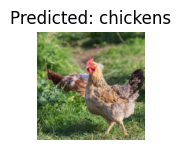

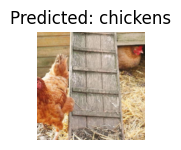

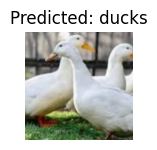

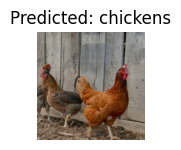

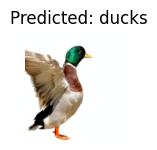

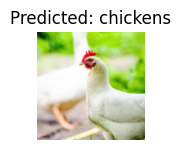

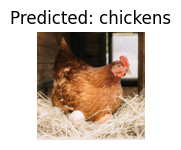

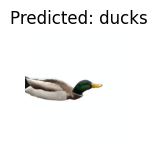

In [10]:
visualize(model_ft)
plt.show()

### CNN as Fixed Feature Extractor

In [11]:
# Load a pre-trained ResNet-18 model with weights pre-trained on ImageNet dataset
model_conv = models.resnet18(weights="IMAGENET1K_V1")

# Freeze the weights of the pre-trained model (set requires_grad to False)
for param in model_conv.parameters():
  param.requires_grad = False

# Get the number of input features from the last fully-connected layer (fc)
num_features = model_conv.fc.in_features

# Modify the last fully-connected layer (fc) of the pre-trained model
#  - Replace the existing layer with a new linear layer
#  - Set the input size of the new layer to the original number of features (num_features)
#  - Set the output size of the new layer to the number of classes in your dataset (len(class_names))
model_conv.fc = nn.Linear(num_features, len(class_names))

# Move the model to the specified device (CPU or GPU)
model_conv = model_conv.to(device)

# Define the loss function used for training
#  - CrossEntropyLoss is commonly used for multi-class classification problems
criterion = nn.CrossEntropyLoss()

# Define the optimizer used for updating model weights during training
#  - SGD (Stochastic Gradient Descent) is a common optimizer
#  - Set learning rate (lr) to 0.001, momentum to 0.9 for parameter updates, but only optimize the parameters of the newly added fc layer
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Define a learning rate scheduler for adjusting the learning rate during training
#  - StepLR scheduler reduces the learning rate by a factor (gamma) every specified number of steps (step_size)
#  - Here, the learning rate will be reduced by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [12]:
model_conv = train_model(model_conv,
                        criterion,
                        optimizer_conv,
                        exp_lr_scheduler,
                        num_epochs = 25)

Epoch 0/24
----------
train Loss: 0.6405 Accuracy: 0.6600
val Loss: 0.1070 Accuracy: 0.9667

Epoch 1/24
----------
train Loss: 0.4089 Accuracy: 0.8250
val Loss: 0.1007 Accuracy: 0.9667

Epoch 2/24
----------
train Loss: 0.3986 Accuracy: 0.8250
val Loss: 0.1590 Accuracy: 0.9500

Epoch 3/24
----------
train Loss: 0.4332 Accuracy: 0.8600
val Loss: 0.0460 Accuracy: 0.9833

Epoch 4/24
----------
train Loss: 0.3485 Accuracy: 0.8550
val Loss: 0.1046 Accuracy: 0.9833

Epoch 5/24
----------
train Loss: 0.1990 Accuracy: 0.9050
val Loss: 0.0400 Accuracy: 0.9833

Epoch 6/24
----------
train Loss: 0.4738 Accuracy: 0.8250
val Loss: 0.0401 Accuracy: 0.9833

Epoch 7/24
----------
train Loss: 0.2210 Accuracy: 0.9150
val Loss: 0.0453 Accuracy: 0.9833

Epoch 8/24
----------
train Loss: 0.3040 Accuracy: 0.8650
val Loss: 0.0481 Accuracy: 0.9833

Epoch 9/24
----------
train Loss: 0.2425 Accuracy: 0.9050
val Loss: 0.0413 Accuracy: 0.9833

Epoch 10/24
----------
train Loss: 0.1523 Accuracy: 0.9200
val Loss: 0

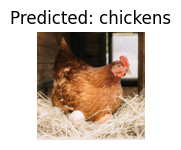

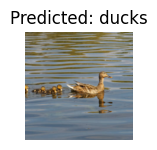

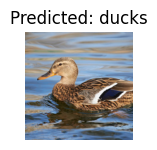

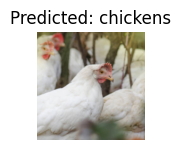

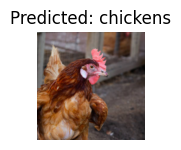

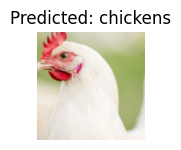

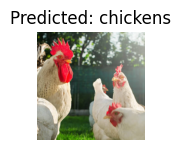

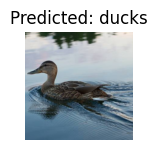

In [13]:
visualize(model_conv)

plt.ioff()
plt.show()

### Inference on Test Images

In [55]:
def visualize_model_predictions(model, image_path, count):
  """
  Visualize the prediction made by the model on a single image.

  Args:
      model: The PyTorch model to use for prediction.
      image_path (str): The path to the image file.
  """

  # Save the current training mode of the model
  was_training = model.training
  
  # Temporarily set the model to evaluation mode for prediction
  model.eval()

  # Open the image using Pillow (PIL Fork) library
  img = Image.open(image_path)
    
  img = img.convert('RGB')
  # Apply the pre-processing steps defined in data_transforms["val"] (likely resizing, normalization, etc.)
  img = data_transforms["val"](img)

  # Add a batch dimension as the model expects a batch of images for input
  img = img.unsqueeze(0)

  # Move the image data to the specified device (CPU or GPU)
  img = img.to(device)
  
    
  # Disable gradient calculation for efficiency during visualization (no backpropagation needed)
  with torch.no_grad():
    # Get model predictions
    outputs = model(img)
    _, preds = torch.max(outputs, 1)  # Get predicted class with highest probability
    
    if count<5:
        # Set plot title with predicted class name
        plt.title("Predicted: {}".format(class_names[preds[0]]))

        # Visualize the image using the show_image function
        show_image(img.cpu().data[0])  # Move data back to CPU for visualization

        # Display the plot
        plt.show()
  # Restore the original training mode of the model
  model.train(mode=was_training)
  return class_names[preds[0]]


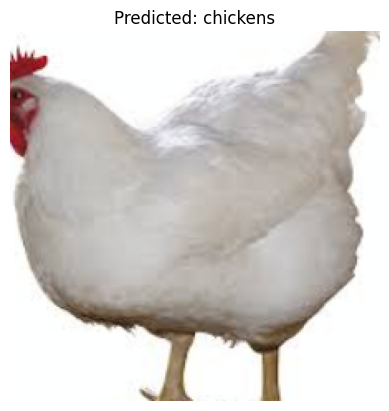

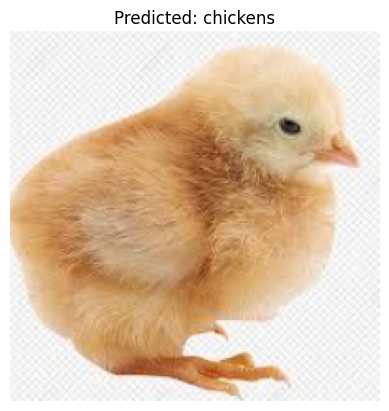

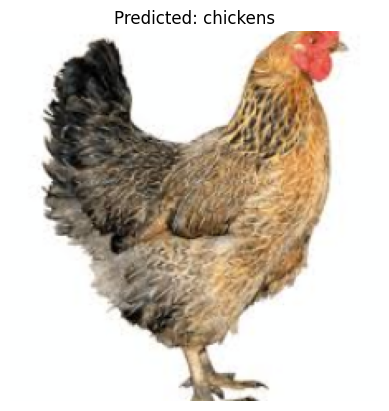

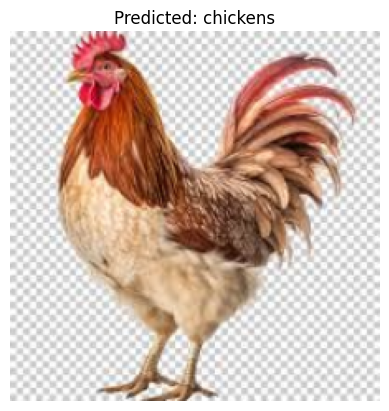

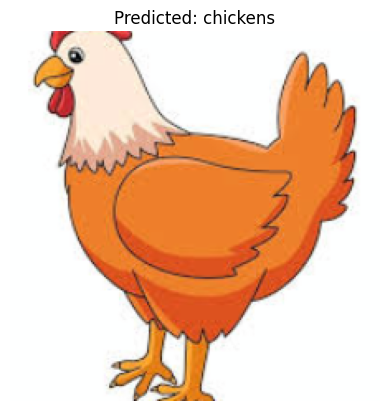

In [60]:
# Define the path to the test image directory
test_images = "/kaggle/input/chicken-duck-data/Image Dataset/test"

# Define paths to subdirectories containing chicken and duck test images
chicken_test_images = glob.glob(f"{test_images}/chickens/*")
duck_test_images = glob.glob(f"{test_images}/ducks/*")

y_true_chickens = ["chickens"]*len(chicken_test_images)
y_true_ducks = ["ducks"]*len(duck_test_images)

y_pred_chickens = []
# Loop through chicken test images and visualize predictions
for image_path in chicken_test_images:
  y_pred_chickens.append(visualize_model_predictions(model_conv, image_path, len(y_pred_chickens)))

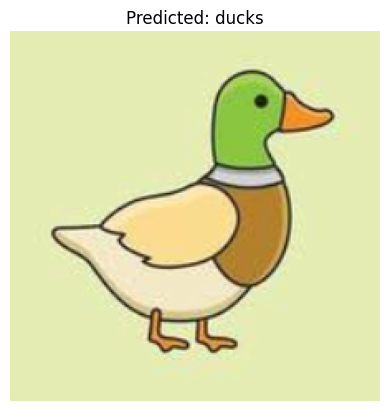

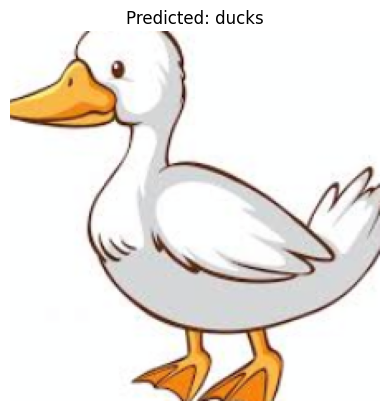

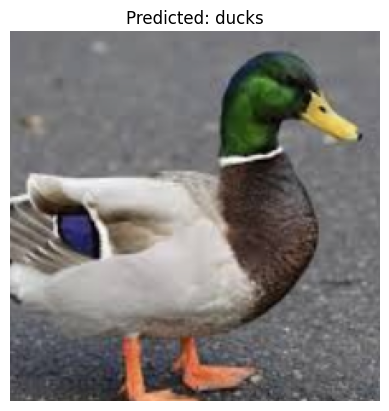

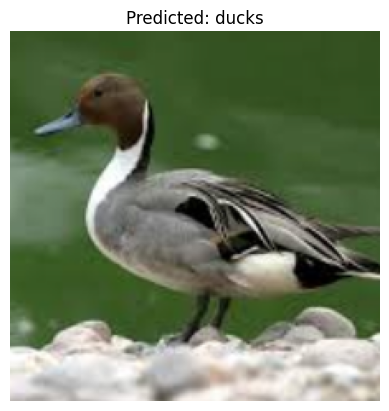

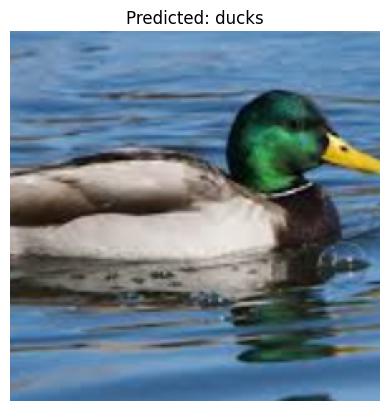

In [61]:
y_pred_ducks = []
# Loop through chicken test images and visualize predictions
for image_path in duck_test_images:
  y_pred_ducks.append(visualize_model_predictions(model_conv, image_path, len(y_pred_ducks)))

In [63]:
y_true = y_true_chickens + y_true_ducks
y_pred = y_pred_chickens + y_pred_ducks
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

    chickens       0.91      0.89      0.90        36
       ducks       0.89      0.92      0.90        36

    accuracy                           0.90        72
   macro avg       0.90      0.90      0.90        72
weighted avg       0.90      0.90      0.90        72

